In [1]:
%matplotlib inline

# Imports

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import torch
import os
import sys
import pickle

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from Utilities import util
from Utilities.rand_generators import GridGenerator
from Utilities.normalization import zscore_normalization, zscore_unnormalization
from Prior_optimization.priors import OptimGaussianPrior
from Samplers.likelihoods import LikGaussian
from Metrics.sampling import compute_rhat_regression
from Prior_optimization.wasserstein_mapper_dwf import MapperWassersteinDWF
from Prior_optimization.gpr import GPR
from Prior_optimization.kernels import RBF
from Prior_optimization.mean_functions import Zero
from Partial_stochasticity.Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Full_stochasticity.Networks.mlp import MLP
from Full_stochasticity.Networks.regression_net import RegressionNet

In [5]:
os.chdir("..")

In [6]:
mpl.rcParams['figure.dpi'] = 300

In [7]:
OUT_DIR = "./exp/1D_regression/wasserstein_dwf"
util.ensure_dir(OUT_DIR)
FIG_DIR = "./exp/1D_regression/wasserstein_dwf"
util.ensure_dir(FIG_DIR)

In [8]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cuda 

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of available GPUs: 1


# Utilities

In [10]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

# Generate Data

In [11]:
util.set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)
# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

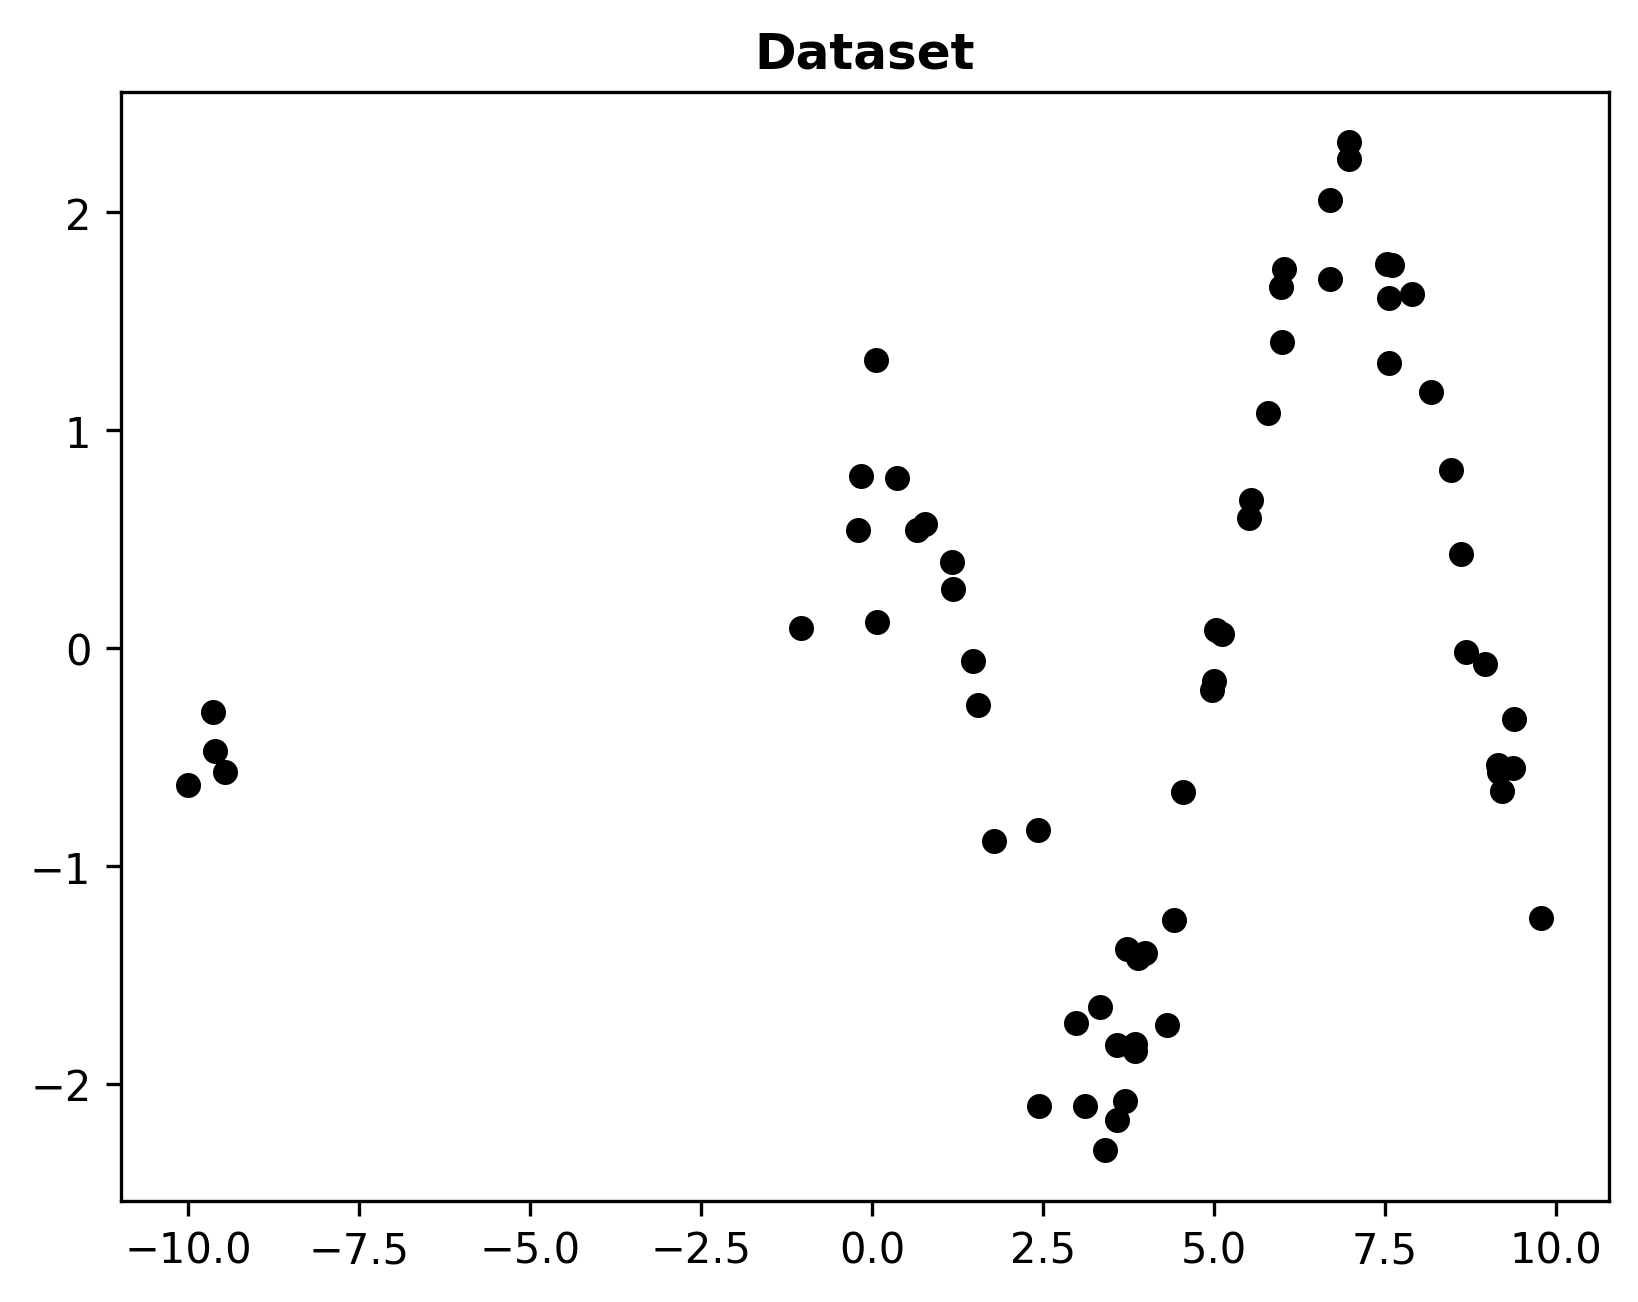

In [12]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset", fontsize = 12, fontweight = 'bold')
plt.show()

In [13]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

## Optimize the Prior using Wasserstein and DWF

In [14]:
# Network setup
util.set_seed(1)
D = 3                   # The factorization depth
width = 50              # Number of units in each hidden layer
depth = 2               # Number of hidden layers
transfer_fn = "tanh"    # Activation function
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
data_generator = GridGenerator(-6, 6)

In [15]:
# Initialize BNN Priors
opt_bnn_sp = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_sp = opt_bnn_sp.to(device)

In [16]:
# GP hyper-parameters
sn2 = 0.1   # noise variance

leng = 0.6  # lengthscale for partially stochastic model
ampl = 1.0  # amplitude for partially stochastic model

# Initialize GP Prior
kernel = RBF(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng], dtype=torch.double),
        variance=torch.tensor([ampl], dtype=torch.double))
gpmodel = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel, mean_function=Zero())
gpmodel.likelihood.variance.set(sn2)
gpmodel = gpmodel.to(device)

In [17]:
mapper_num_iters = 800 # Define the number of iterations of Wasserstein optimization

In [18]:
# Initiialize the Wasserstein optimizer
util.set_seed(1)
mapper = MapperWassersteinDWF(gpmodel, opt_bnn_sp, data_generator,
                           out_dir=OUT_DIR, lambd = (torch.tensor([1.5, 1.75, 2.])/D).to(device), 
                           wasserstein_steps=(0, 1000),
                           wasserstein_lr=0.08,
                           n_data=200, n_gpu=1, gpu_gp=True)

# Start optimizing the prior
loss_hist, w_hist = mapper.optimize(num_iters=mapper_num_iters, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
wsr_path = os.path.join(OUT_DIR, "wsr_values.log")
np.savetxt(wsr_path, w_hist, fmt='%.6e')      
pruned_path = os.path.join(OUT_DIR, "pruned_values.log") 
np.savetxt(pruned_path, loss_hist, fmt='%.6e')     
with open(os.path.join(OUT_DIR, "masks_list.pkl"), "wb") as f:
    pickle.dump(opt_bnn_sp.get_det_masks(), f)

>>> Iteration #   1: Wasserstein Dist 17.0219 Number of pruned weights   0
>>> Iteration #  20: Wasserstein Dist 12.2585 Number of pruned weights   0
>>> Iteration #  40: Wasserstein Dist 12.2136 Number of pruned weights   0
>>> Iteration #  60: Wasserstein Dist 11.7252 Number of pruned weights   0
>>> Iteration #  80: Wasserstein Dist 11.3789 Number of pruned weights   0
>>> Iteration # 100: Wasserstein Dist 11.0190 Number of pruned weights   0
>>> Iteration # 120: Wasserstein Dist 11.4905 Number of pruned weights   0
>>> Iteration # 140: Wasserstein Dist 11.5020 Number of pruned weights   0
>>> Iteration # 160: Wasserstein Dist 11.2580 Number of pruned weights   0
>>> Iteration # 180: Wasserstein Dist 10.2370 Number of pruned weights   0
>>> Iteration # 200: Wasserstein Dist 10.3265 Number of pruned weights   0
>>> Iteration # 220: Wasserstein Dist 11.1575 Number of pruned weights   0
>>> Iteration # 240: Wasserstein Dist 10.3158 Number of pruned weights   0
>>> Iteration # 260: Wass

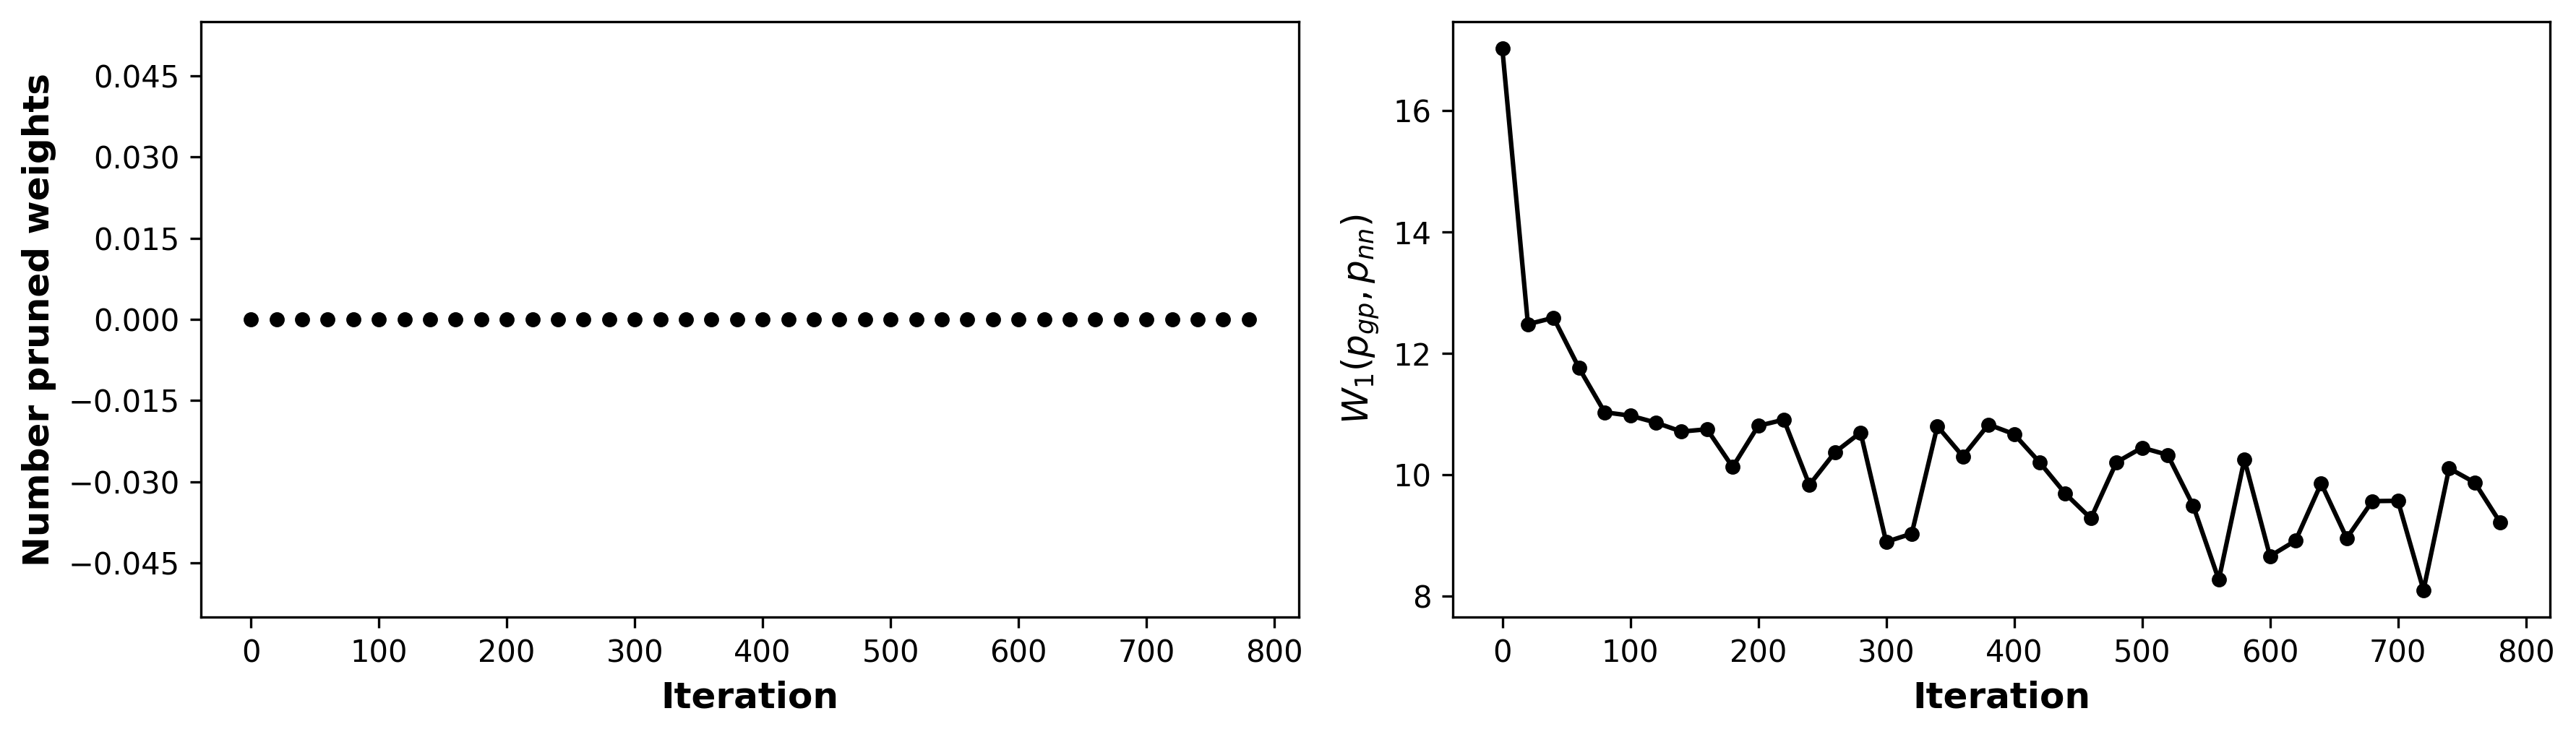

In [19]:
# Visualize progression of the prior optimization
indices = np.arange(mapper_num_iters)[::20]
p_hist = np.loadtxt(pruned_path)
loss_hist = np.loadtxt(wsr_path)
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights", fontsize = 12, fontweight = 'bold')
axes[0].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, loss_hist[indices], "-ko", ms=4)
axes[1].set_ylabel(r"$W_1(p_{gp}, p_{nn})$", fontsize = 12, fontweight = 'bold')
axes[1].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "prior_optimization")
plt.savefig(fig_path)
plt.show()

## Compare Functional Prior to GP

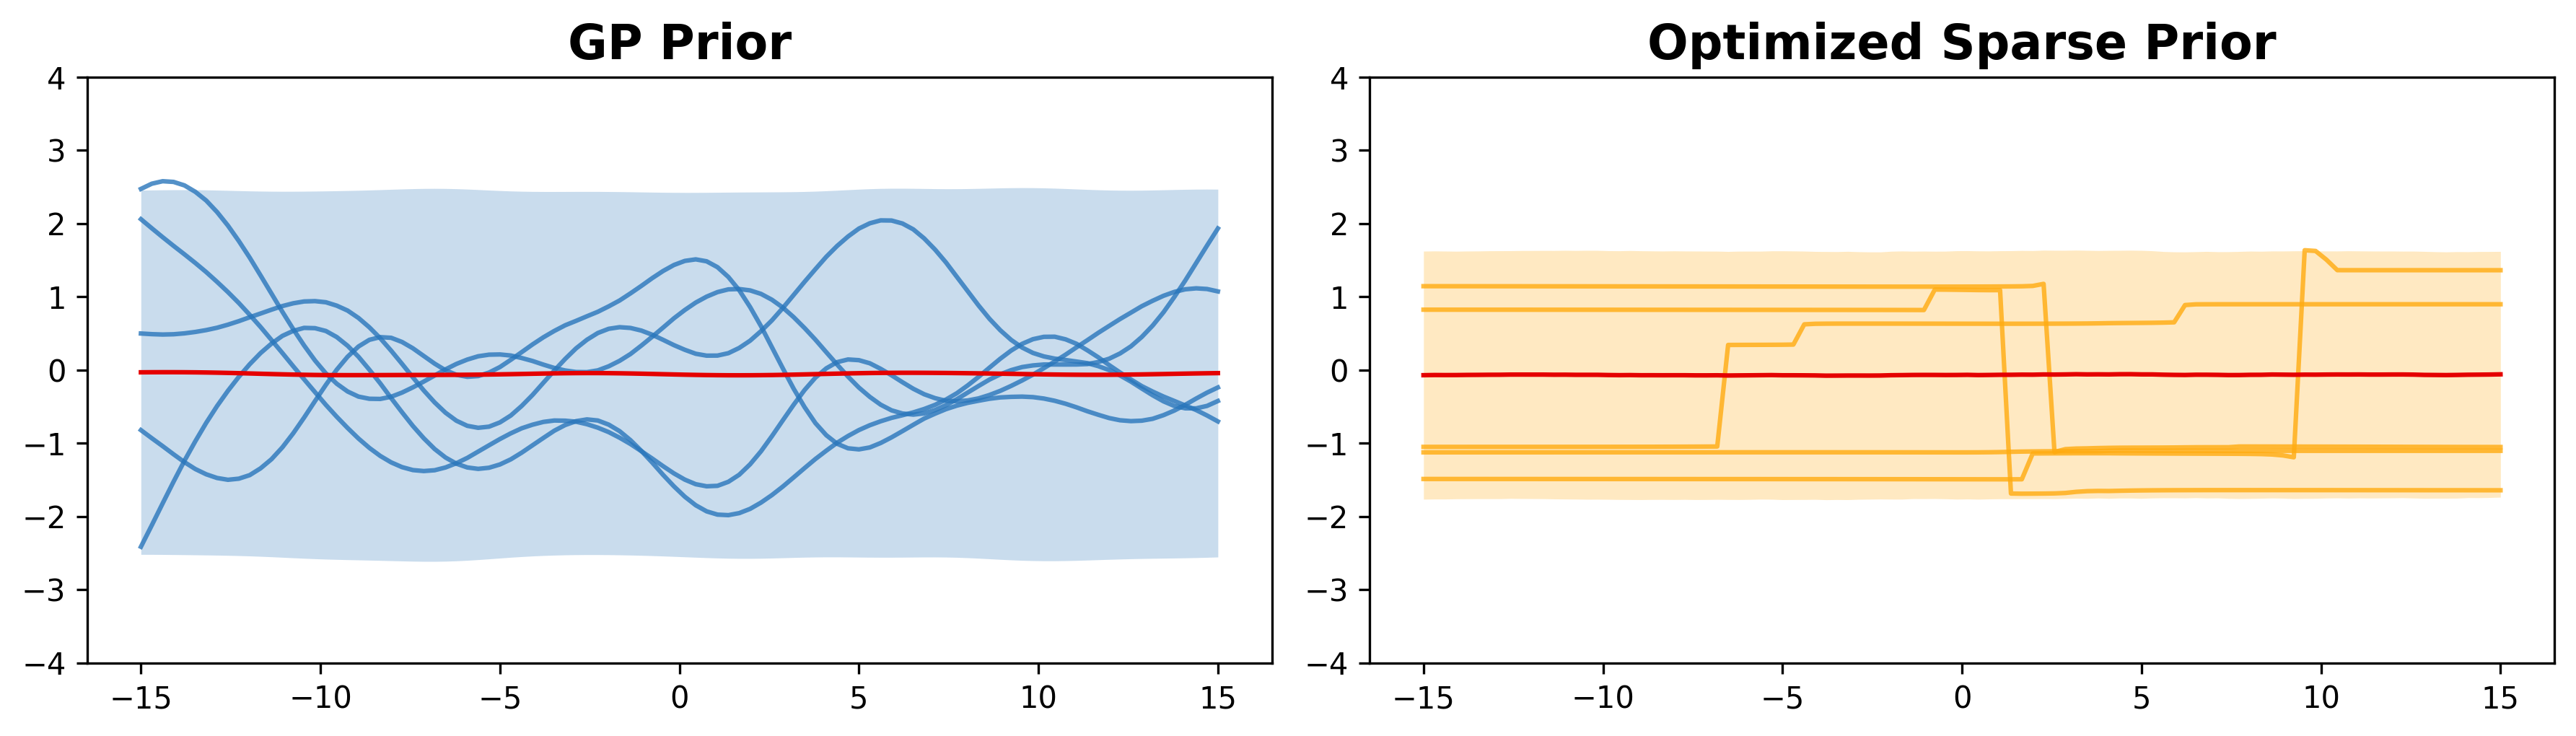

In [20]:
# Draw functions from the priors
util.set_seed(8)
n_plot = 4000
sparse_opt_samples = opt_bnn_sp.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples = zscore_unnormalization(sparse_opt_samples, y_mean, y_std)

gp_samples = gpmodel.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples = zscore_unnormalization(gp_samples, y_mean, y_std)

fig, axs = plt.subplots(1,2, figsize=(12, 3.5))

plot_samples(Xtest, gp_samples, ax=axs[0], n_keep=5)
axs[0].set_title('GP Prior', fontsize = 16, fontweight = 'bold')
axs[0].set_ylim([-4,4])

plot_samples(Xtest, sparse_opt_samples, ax=axs[1], color='xkcd:yellowish orange', n_keep=5)
axs[1].set_title('Optimized Sparse Prior', fontsize = 16, fontweight = 'bold')
axs[1].set_ylim([-4,4])

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "functional_prior")
plt.savefig(fig_path)
plt.show()

## Predictive Posterior

In [20]:
# SGHMC Hyper-parameters
sampling_configs = {
    "batch_size": 32,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5
}

In [21]:
# Load the optimized prior
util.set_seed(1)
likelihood = LikGaussian(sn2)
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
prior = OptimGaussianPrior(ckpt_path)
# Setup of the network
net = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim")
util.ensure_dir(saved_dir)
net_optim = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
# Start sampling
net_optim.sample_multi_chains(X, y, **sampling_configs)

Chain: 0
Samples #     5 : NLL =  2.8621e-01 RMSE = 2.5040e-01 
Samples #    10 : NLL =  3.0558e-01 RMSE = 2.3922e-01 
Samples #    15 : NLL =  2.9619e-01 RMSE = 2.3371e-01 
Samples #    20 : NLL =  2.9643e-01 RMSE = 2.2990e-01 
Chain: 1
Samples #    25 : NLL =  2.9299e-01 RMSE = 2.2722e-01 
Samples #    30 : NLL =  2.9036e-01 RMSE = 2.2599e-01 
Samples #    35 : NLL =  2.9025e-01 RMSE = 2.2379e-01 
Samples #    40 : NLL =  2.9070e-01 RMSE = 2.2246e-01 
Chain: 2
Samples #    45 : NLL =  2.9054e-01 RMSE = 2.2232e-01 
Samples #    50 : NLL =  2.9480e-01 RMSE = 2.2072e-01 
Samples #    55 : NLL =  2.9760e-01 RMSE = 2.1724e-01 
Samples #    60 : NLL =  2.9997e-01 RMSE = 2.1490e-01 
Chain: 3
Samples #    65 : NLL =  2.9467e-01 RMSE = 2.1284e-01 
Samples #    70 : NLL =  2.9119e-01 RMSE = 2.1186e-01 
Samples #    75 : NLL =  2.9005e-01 RMSE = 2.1128e-01 
Samples #    80 : NLL =  2.8948e-01 RMSE = 2.1070e-01 


In [22]:
# Make predictions
_, _, optim_preds = net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(optim_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
optim_preds = optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=optim_preds)

R-hat: mean 1.0384 std 0.0713


## Visualise predictive posterior

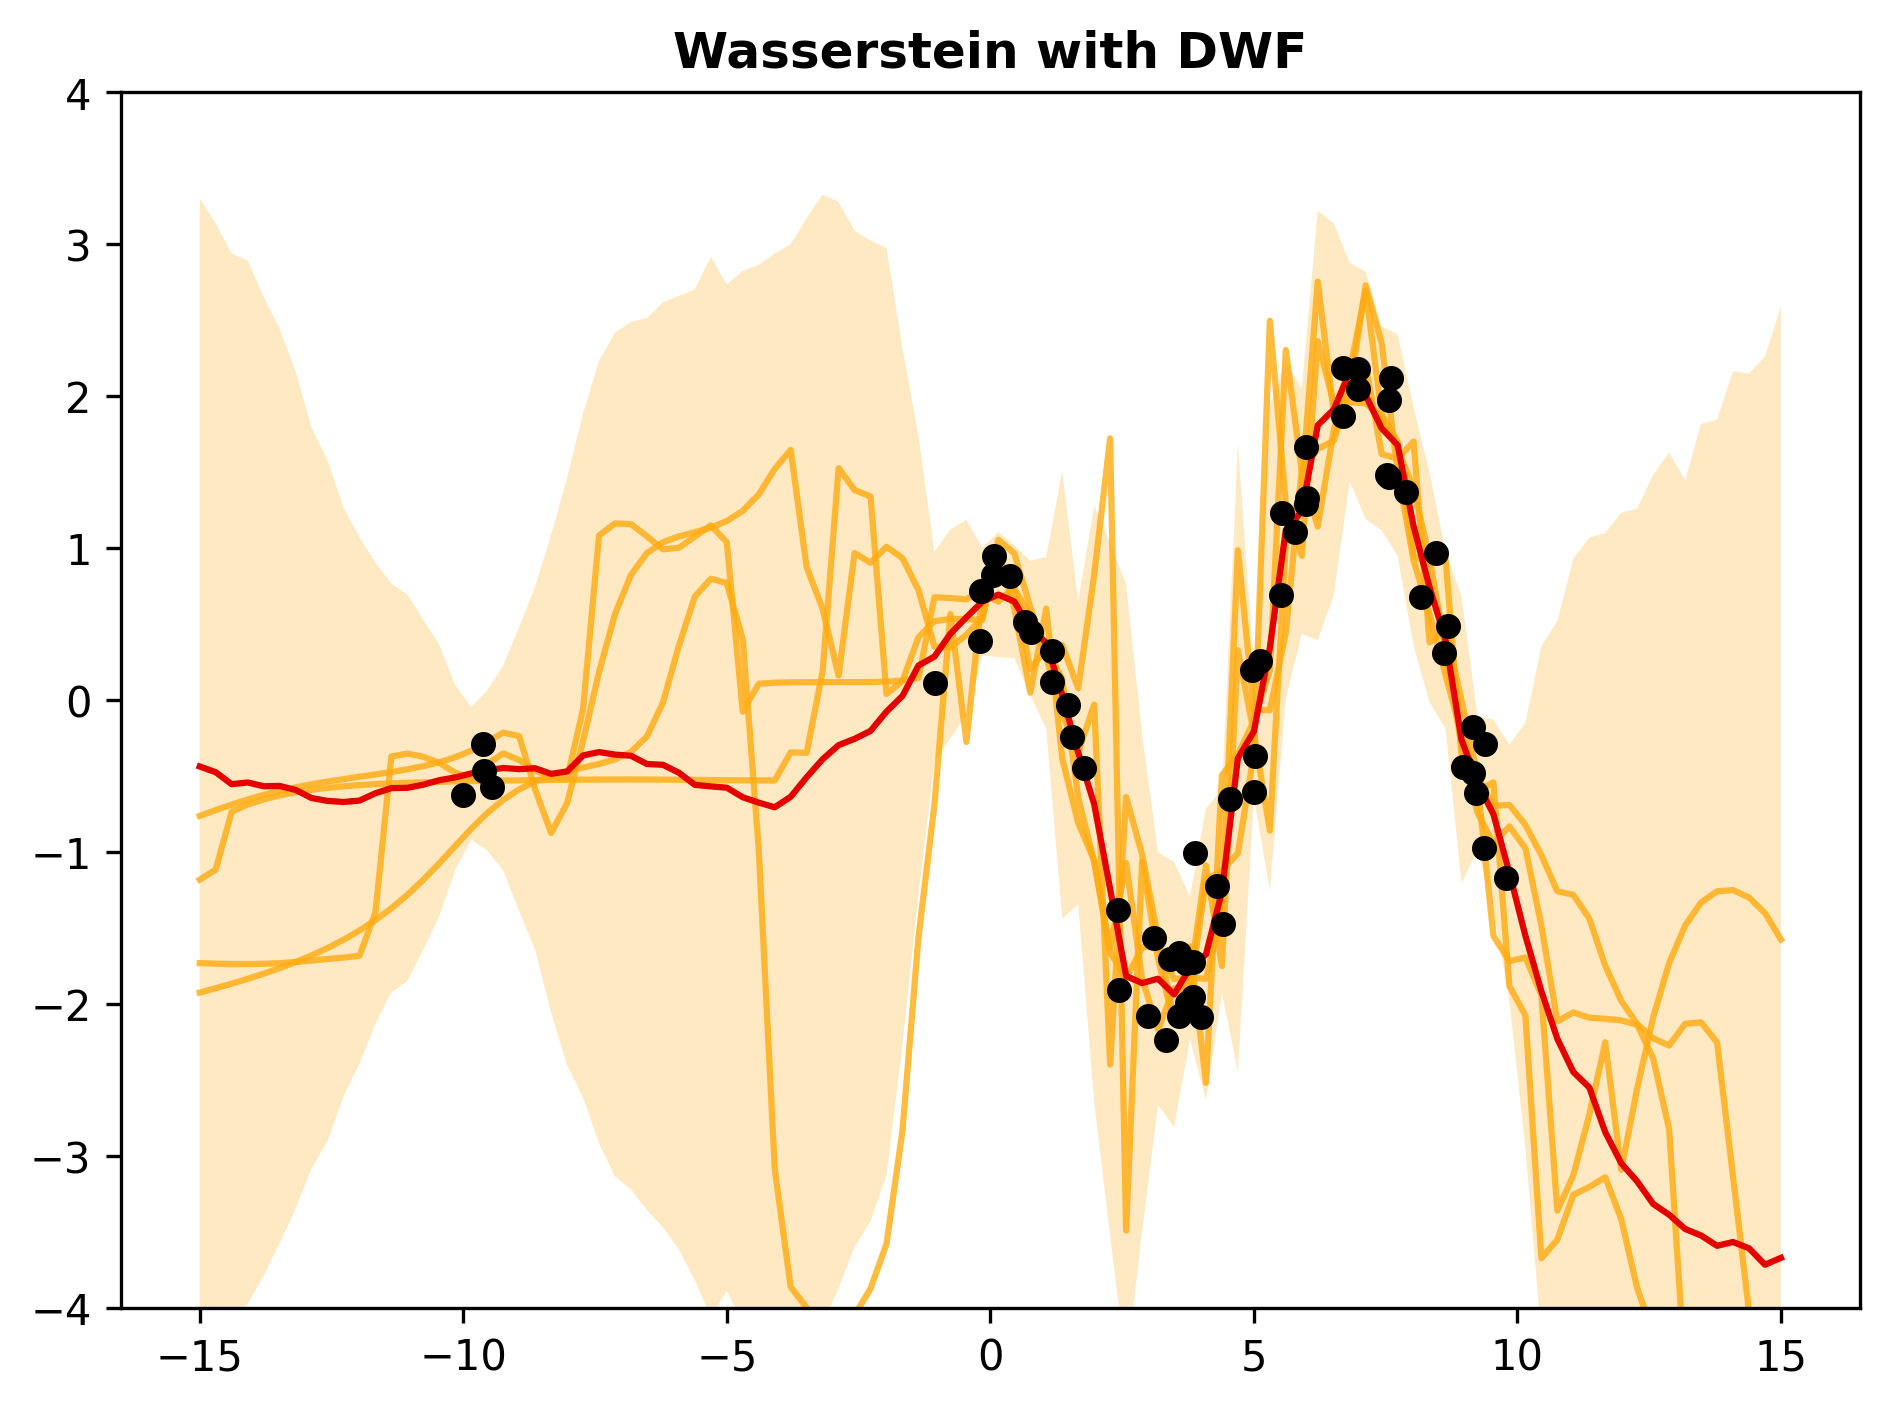

In [23]:
util.set_seed(4)

plot_samples(Xtest, optim_preds, color='xkcd:yellowish orange', n_keep=4)
plt.plot(X, y, 'ok', zorder=10, ms=5)
plt.title("Wasserstein with DWF", fontsize = 12, fontweight = 'bold')
plt.ylim([-4, 4])

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "predictive_posterior")
plt.savefig(fig_path)
plt.show()